In [1]:
%matplotlib inline

from __future__ import print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from math import ceil
from utils import *
from magnet_ops import *
from magnet_tools import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class MNISTEncoder(object):
    def __init__(self, emb_dim, sess):
        self.emb_dim = emb_dim
        self.sess = sess
        
        self.inputs = tf.placeholder("float32", [None, 28*28])
        self.labels = tf.placeholder("bool", [None])
        
        self._build_model()

    def _build_model(self):
        # Convolutional encoder
        x_image = tf.reshape(self.inputs, [-1,28,28,1])

        self.W_conv1 = weight_variable([5, 5, 1, 32])
        self.b_conv1 = bias_variable([32])
        self.h_conv1 = tf.nn.relu(conv2d(x_image, self.W_conv1) + self.b_conv1)
        self.h_pool1 = max_pool_2x2(self.h_conv1)

        self.W_conv2 = weight_variable([5, 5, 32, 64])
        self.b_conv2 = bias_variable([64])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_pool1, self.W_conv2) + self.b_conv2)
        self.h_pool2 = max_pool_2x2(self.h_conv2)

        self.W_fc1 = weight_variable([7 * 7 * 64, self.emb_dim])
        self.b_fc1 = bias_variable([self.emb_dim])

        h_pool2_flat = tf.reshape(self.h_pool2, [-1, 7*7*64])
        self.emb = tf.matmul(h_pool2_flat, self.W_fc1) + self.b_fc1

        # L2 normalize
        self.norm_emb = tf.nn.l2_normalize(self.emb, 1)

    def get_norm_embedding(self, batch):
        return self.sess.run(self.norm_emb, feed_dict={self.inputs: batch})        
        
    def get_embedding(self, batch):
        return self.sess.run(self.emb, feed_dict={self.inputs: batch})

0 2.3119025
Refreshing clusters
200 0.8691006
400 0.34299558
600 0.49810362
800 0.19378674
Refreshing clusters
1000 0.677706
1200 1.2230024
1400 1.2094359
1600 0.6360254
Refreshing clusters
1800 0.8457773
2000 0.91965723
2200 0.55121845
2400 1.5138791
Refreshing clusters
2600 1.090491
2800 1.1813366
3000 0.8909234
3200 0.5802792
3400 1.5078685
Refreshing clusters
3600 0.6470355
3800 0.39412695
4000 0.85486746
4200 1.1129159
Refreshing clusters
4400 0.5207046
4600 0.57068455
4800 0.44854856
5000 0.64136606
Refreshing clusters
5200 0.45898125
5400 0.4164448
5600 0.26129565
5800 0.084184974
6000 1.1666965
Refreshing clusters
6200 0.46405196
6400 0.9407882
6600 0.18559343
6800 0.7067623
Refreshing clusters
7000 0.7877493
7200 0.87881094
7400 0.65786135
7600 0.34493497
Refreshing clusters
7800 0.23443323
8000 0.3211671
8200 0.3884706
8400 0.94562685
8600 0.32169223
Refreshing clusters
8800 0.34054172
9000 0.26245305
9200 0.18682303
9400 0.59446084
Refreshing clusters
9600 0.1532527
9800 0.5

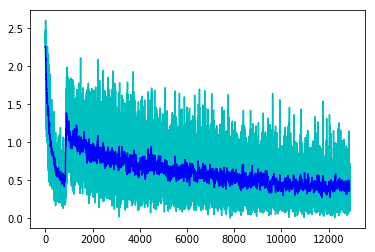

In [3]:
# Define magnet loss parameters
m = 8
d = 8
k = 3
alpha = 1.0
batch_size = m * d

# Define training data
X = mnist.train.images
y = mnist.train.labels

# Define model and training parameters
emb_dim = 2
n_epochs = 15
epoch_steps = int(ceil(float(X.shape[0]) / batch_size)) 
n_steps = epoch_steps * 15
cluster_refresh_interval = epoch_steps


sess = tf.InteractiveSession()

# Model
with tf.variable_scope('model'):
    model = MNISTEncoder(emb_dim, sess)

# Loss
with tf.variable_scope('magnet_loss'):
    class_inds = tf.placeholder(tf.int32, [m*d])
    train_loss, losses = minibatch_magnet_loss(model.emb, class_inds, m, d, alpha)

train_op = tf.train.AdamOptimizer(1e-4).minimize(train_loss)

sess.run(tf.global_variables_initializer())


# Get initial embedding
extract = lambda x: sess.run(model.emb, feed_dict={model.inputs: x})
initial_reps = compute_reps(extract, X, 400)


# Create batcher
batch_builder = ClusterBatchBuilder(mnist.train.labels, k, m, d)
batch_builder.update_clusters(initial_reps)

batch_losses = []
for i in range(n_steps):
    
    # Sample batch and do forward-backward
    batch_example_inds, batch_class_inds = batch_builder.gen_batch()
    feed_dict = {model.inputs: X[batch_example_inds], class_inds: batch_class_inds}
    _, batch_loss, batch_example_losses = \
        sess.run([train_op, train_loss, losses], feed_dict=feed_dict)
    
    # Update loss index
    batch_builder.update_losses(batch_example_inds, batch_example_losses)
    
    batch_losses.append(batch_loss)
    if not i % 200:
        print(i, batch_loss)
    
    if not i % cluster_refresh_interval:
        print('Refreshing clusters')
        reps = compute_reps(extract, X, 400)
        batch_builder.update_clusters(reps)
        
final_reps = compute_reps(extract, X, 400)
    
sess.close()
tf.reset_default_graph()

# Plot loss curve
plot_smooth(batch_losses)

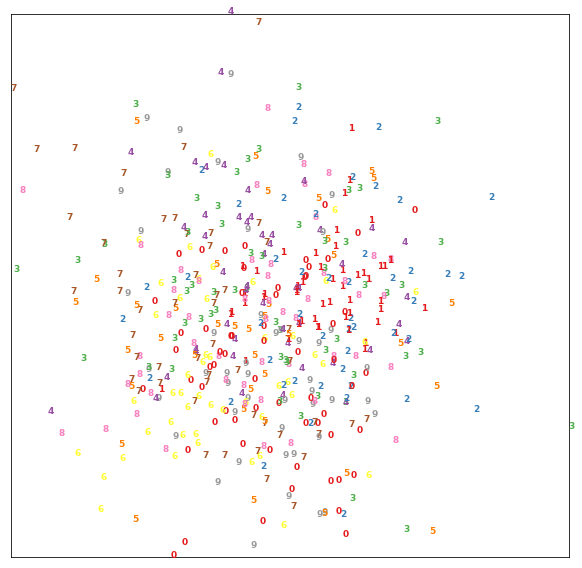

In [4]:
n_plot = 500
imgs = mnist.train.images[:n_plot]
imgs = np.reshape(imgs, [n_plot, 28, 28])
plot_embedding(initial_reps[:n_plot], mnist.train.labels[:n_plot])

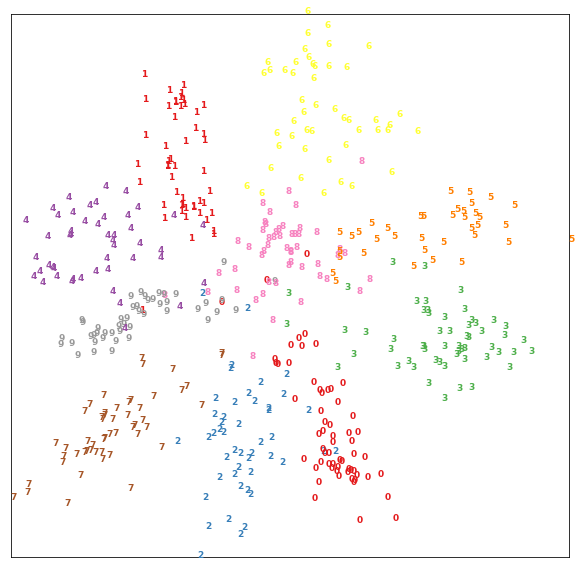

In [5]:
n_plot = 500
imgs = mnist.train.images[:n_plot]
imgs = np.reshape(imgs, [n_plot, 28, 28])
plot_embedding(final_reps[:n_plot], mnist.train.labels[:n_plot])